# SurrogateTools
## Example Workflow
In this workflow we demonstrate how a Gaussian process (GP) surrogate may be constructed for an arbitrary set of data. Here, we use a set of stress-strain curves produced using a crystal plasticity (CP) phenomenological model which has four fitting parameters. 

The purpose of this notebook is to create a surrogate model for a simulation $\mathbf{f}(\mathbf{x},\boldsymbol{\theta})$ which predicts an output vector $\mathbf{y}(\mathbf{x})$ as a function of some input variable $\mathbf{x}$, in our case, our output is a stress vector $\boldsymbol{\sigma}(\boldsymbol{\epsilon})$ sampled at regular strain intervals. We also introduce an error term $\boldsymbol{\epsilon_1}$, which we wish to minimise. The parameters of the model are given by $\boldsymbol{\theta}$. This may be represented by,

$\mathbf{f}(\mathbf{x},\boldsymbol{\theta}) = \mathbf{y}(\mathbf{x})  + \boldsymbol{\epsilon_1}(\boldsymbol{\theta})$.

The surrogate model $\boldsymbol{\mathcal{M}}(\boldsymbol{\theta})$ is a function of the input parameters, but does not encode any information about the additional variable $\mathbf{x}$. For the purpose of this workbook, GPs will be used as a surrogate model, with the following form,

$\boldsymbol{\mathcal{M}}(\boldsymbol{\theta}) = \mathbf{f}(\mathbf{x},\boldsymbol{\theta}) + \boldsymbol{\epsilon_2}(\boldsymbol{\theta})$

where we again have a surrogate error term $\boldsymbol{\epsilon_2}$, which we wish to minimise.

For clarity, the following variables `Y_train, Y_test` denote the training and testing data for $\mathbf{y}$ and `X_train, X_test` confusingly denotes the parameters $\boldsymbol{\theta}$, as we want to avoid having to write `theta` at the start of all our input variables. The values of $\mathbf{x}$ may be included for plotting purpose or for calculating gradients, however, this has been omitted for simplicity in this notebook.

### Load Imports

In [1]:
import surrogatetools
import numpy as np
import matplotlib.pyplot as plt
import sklearn

### Define X and Y data
Here, we import the values from the example dataset. 

In [2]:
X_train = np.loadtxt('data/X_train.txt')
Y_train = np.loadtxt('data/Y_train.txt')
X_test = np.loadtxt('data/X_test.txt')
Y_test = np.loadtxt('data/Y_test.txt')

### Initialise the surrogate
We need to provide the training data as well as the names of the input parameters. We also scale the data, as GPs require normalised data for accurate predictions. 

In [3]:
surrogate = surrogatetools.Surrogate(X_train,Y_train,parameter_names=['a_1','a_2','a_3','a_4'])
surrogate.scale_data()

### Build the surrogate
Now we need to build the surrogate, here we have a few additional options. We can choose a custom kernel for the GP by provided on through the `kernel` keyword, and we can also cross-validate on the training data and use custom scoring metrics when doing so. If cross-validating, then the surrogate will be training on the entire training after the cross-validation is complete. Additional `**kwargs` may be passed to `sklearn.gaussian_process.GaussianProcessRegressor` when building the model.

In [4]:
surrogate.build_model(n_restarts_optimizer=5,
                        cross_validate=True,
                        scoring='r2',
                        normalize_y=True)

/Users/user/micromamba/envs/testenv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 19 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/user/micromamba/envs/testenv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Cross validation score:  [1. 1. 1. 1. 1.]


### Validate against the testing data
We can validate the surrogate model using the testing data and calculating the regression coefficient.

In [5]:
Y_prediction, Y_error = surrogate.make_prediction(X_test,return_std=True)
score = sklearn.metrics.r2_score(Y_test,Y_prediction)

print('r2 score',np.round(score,4))

r2 score 0.9997


### Visualise the data
Now for good practice we should select some of the testing data and the surrogate predictions for a qualitative comparison to ensure our surrogate uncertainty is not unreasonably high. 

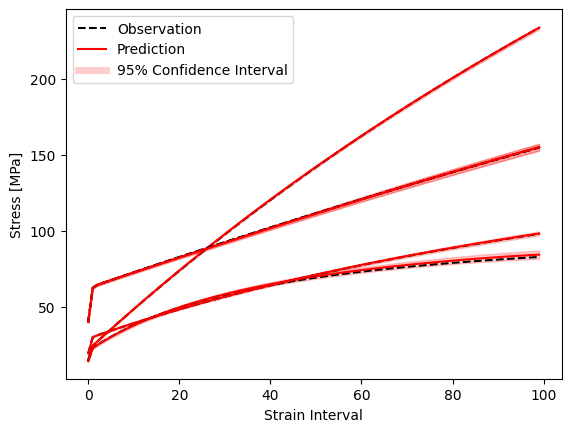

In [6]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

random_samples = np.random.randint(low=0,high=len(X_test), size=5)

for idx in random_samples:
    plt.fill_between(range(len(Y_prediction[idx])), Y_prediction[idx]+2*Y_error[idx],Y_prediction[idx]-2*Y_error[idx],alpha=0.2,color='r')
    plt.plot(Y_test[idx],color='k',linestyle='dashed')
    plt.plot(Y_prediction[idx],color='r')

plt.xlabel('Strain Interval')
plt.ylabel('Stress [MPa]')

legend_elements = [Line2D([0], [0], color='k', label='Observation',ls='dashed'),
                   Line2D([0], [0], color='r', label='Prediction'),
                   Line2D([0], [0], color='r', label='95% Confidence Interval', lw=5,alpha=0.2)]

plt.legend(handles=legend_elements)

### Fit the surrogate to experimental data
Now we can fit the model to some experimental data which has uncertainty. Here we just select a sample from the testing data and assign a 1.0% error to the values. The surrogate uses a SHGO global optimiser in Scipy to find the global minimum. We can include the surrogate error in the calculation using `use_std`. Additional `**kwargs` may be passed to `scipy.optimize.shgo`.

For clarity, the loss function is defined as,

$ \mathcal{l}(\boldsymbol{\theta}) = \frac{
    \left(\boldsymbol{y}(\mathbf{x},\boldsymbol{\theta}) - \mathcal{M}(\boldsymbol{\theta})\right)^2 
    + \epsilon_{\mathcal{M}}(\boldsymbol{\theta})^2}
    {\boldsymbol{\sigma}^2}$

where $\boldsymbol{\sigma}$ is the uncertainty in the experimental data, and $\epsilon_{\mathcal{M}}(\boldsymbol{\theta})$ is the uncertainty in the surrogate model predictions. Including the surrogate error effectively penalises the loss in regions with high uncertainty and encourages the optimiser to find solutions close to known minima. Otherwise, the optimiser may become stuck in the edges of the parameter space where a possible minima may exist, albeit with huge uncertainty. 

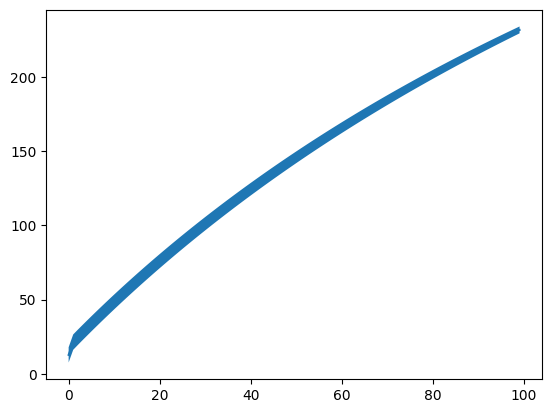

In [27]:
idx = 1
data = Y_test[idx]
X_true = X_test[idx]
error = np.linspace(5,0,len(Y_test[idx])) + data*0.01

plt.plot(data)
plt.fill_between(range(len(data)), data+error,data-error)

In [28]:
res = surrogate.fit(Y_actual=data,
                    Y_error=error,                        
                    use_std=True
                    )

print(res)

 message: Optimization terminated successfully.
 success: True
     fun: 840.723063318789
    funl: [ 8.407e+02]
       x: [ 1.885e+00  2.018e+07  2.697e+08  2.501e+08]
      xl: [[ 1.885e+00  2.018e+07  2.697e+08  2.501e+08]]
     nit: 1
    nfev: 116
   nlfev: 99
   nljev: 9
   nlhev: 0


### Peform Bayesian inference
Now that we have a global minimum we can use it as the MAP for the MCMC process, which gives a good starting guess on the mode of the posterior distribution. Additional `**kwargs` may be passed to `pymc.sample`.

In [29]:
import pymc as pm

inference_data = surrogate.perfom_inference(Y_actual=data,
                                            Y_error=error,
                                            draws=50_000,
                                            tune=50_000,
                                            chains=4,
                                            cores=4,
                                            return_inferencedata=True,
                                            #initval=res.x,
                                            use_std=True
                                            )

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [a_1, a_2, a_3, a_4]
INFO:pymc.sampling.mcmc:DEMetropolisZ: [a_1, a_2, a_3, a_4]


Output()

Sampling 4 chains for 50_000 tune and 50_000 draw iterations (200_000 + 200_000 draws total) took 39 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 50_000 tune and 50_000 draw iterations (200_000 + 200_000 draws total) took 39 seconds.


In [30]:
import arviz as az

az.summary(inference_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_1,2.009000e+00,4.600000e-01,1.271000e+00,2.906000e+00,0.012,0.007,1163.0,658.0,1.00
a_2,7.025630e+06,6.962730e+05,5.715890e+06,8.316647e+06,10849.865,6427.562,4122.0,5846.0,1.00
a_3,2.838896e+08,5.464407e+07,1.800771e+08,3.867710e+08,1495710.467,1069055.182,1449.0,1315.0,1.01
a_4,2.929423e+08,9.519416e+06,2.755166e+08,3.111571e+08,173593.039,101256.098,3002.0,3963.0,1.00


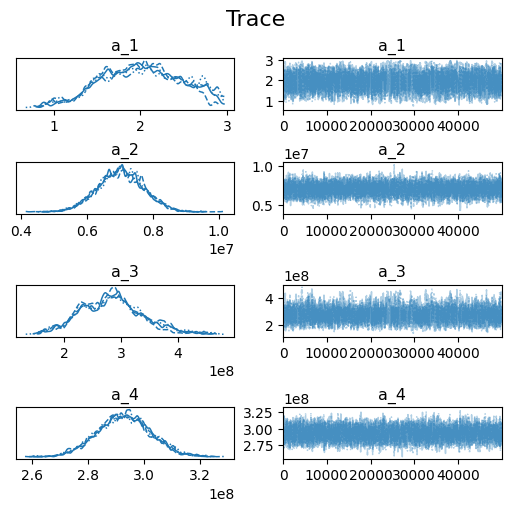

In [31]:
az.summary(inference_data)

#lines = [(x,{},y) for x,y in zip(surrogate.parameter_names,res.x)]

axes = az.plot_trace(
    data=inference_data,
    compact=True,
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
    #lines=lines,
)
plt.gcf().suptitle("Trace", fontsize=16)
plt.gcf().set_figwidth(5)
plt.gcf().set_figheight(5)

### Extract Posterior Information
Now that we have the posterior distribution, we should calculate the mean, mode and standard deviation for each parameter.

In [34]:
import scipy
X_posterior = np.array([np.array(inference_data.posterior[x]).flatten() for x in surrogate.parameter_names]).T

X_mode = np.array([scipy.stats.mode(X_posterior[:,i])[0] for i in range(surrogate.D)])
X_mean = np.array([np.mean(X_posterior[:,i]) for i in range(surrogate.D)])
X_std = np.array([np.std(X_posterior[:,i]) for i in range(surrogate.D)])


surrogate.parameter_mean = X_mean
surrogate.parameter_std = X_std

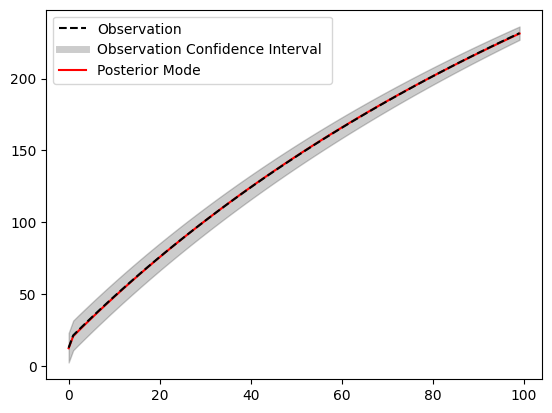

In [33]:
plt.plot(surrogate.make_prediction(X_mode.reshape(1, -1))[0],color='r')

plt.plot(data,color='k',ls='--')
plt.fill_between(range(len(data)),data+2*error,data-2*error,color='k',alpha=0.2)

legend_elements = [Line2D([0], [0], color='k', label='Observation',ls='dashed'),
                   Line2D([0], [0], color='k', label='Observation Confidence Interval ', lw=5,alpha=0.2),
                   Line2D([0], [0], color='r', label='Posterior Mode'),
]

plt.legend(handles=legend_elements)

## Local Sensitivity Analysis

In [53]:
indices = surrogate.generate_sobol(use_fit=True,n=2**10)

boot = indices.bootstrap()

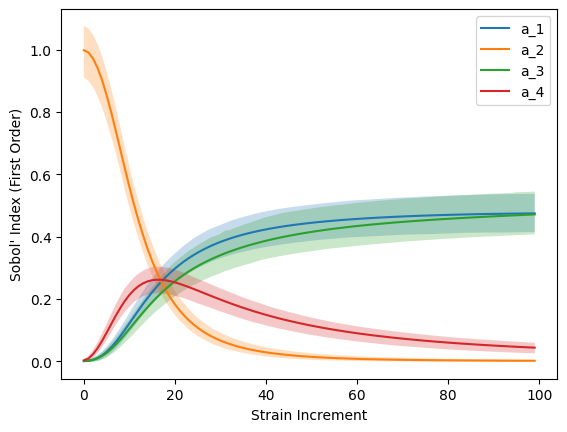

In [58]:
for i in range(surrogate.D):

    plt.fill_between(x=range(len(boot.first_order.confidence_interval.high[:,i])),
                    y1=boot.first_order.confidence_interval.high[:,i],
                    y2=boot.first_order.confidence_interval.low[:,i],
                    alpha=0.25)
    
    plt.plot(indices.first_order[:,i], label=surrogate.parameter_names[i])

plt.xlabel('Strain Increment')
plt.ylabel('Sobol\' Index (First Order)')
plt.legend()